李沐刚好有这个竞赛的[视频教程](https://www.bilibili.com/video/BV1NK4y1P7Tu?spm_id_from=333.788.videopod.episodes&vd_source=8924ad59b4f62224f165e16aa3d04f00)，跟着做一下

In [1]:
import sys
sys.path.append('./../../') #d2l here
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"#不加这行 在跑d2l代码时内核可能崩溃
import hashlib
import os
import tarfile
import zipfile
import requests
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils import data
from d2l import torch as d2l
%matplotlib inline

In [2]:
train_data = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test_data = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [3]:
print(train_data.iloc[0:4,[0,1,2,3,-3,-2,-1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


在每个样本中，第一个特征是ID，删掉。

In [4]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
all_features.shape

(2919, 79)

将所有缺失的值替换为相应特征的平均值。通过将特征重新缩放到零均值和单位方差来标准化数据  
“这里是把训练和测试集放在一起算均值方差，因为比赛已经有测试集了，实际情况不一定能这么做”

In [5]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
all_features[numeric_features] = all_features[numeric_features].fillna(0)

处理离散值，用一次独热编码替换它们
“某列有五类值，就将此列等价为五列，对应的列置1，不存在的列置0”

In [6]:
all_features = pd.get_dummies(all_features, dummy_na = True)
all_features.shape

(2919, 330)

从`pandas`格式中提取NumPy格式，并将其转换为张量表示

In [7]:
n_train = train_data.shape[0]
all_features = all_features * 1
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1,1), dtype=torch.float32)
#.reshape(-1,1) 转化为一个二维数组，第一维大小自动计算，第二维大小为1
print(n_train)
print(train_features.shape)
print(test_features.shape)
print(train_labels.shape)

1460
torch.Size([1460, 330])
torch.Size([1459, 330])
torch.Size([1460, 1])


**训练**

In [8]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1))
    return net
#创建了一个神经网络模型，只有一层，这一层是一个线性回归模型(nn.Linear)，这个线性回归模型输入数据的维度是in_features，输出数据的维度是1

这里更关心相对误差，而不是绝对误差(以防便宜的房子对预测结果的影响小于贵的房子)。解决这个问题的一种方法是用价格预测的对数来衡量差异

In [9]:
def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features),1 , float('inf'))
    #上一行 把`net(features)`的结果限制在1到inf,小于1的值会直接被赋值为1
    rmse = torch.sqrt(loss(torch.log(clipped_preds),torch.log(labels)))#预测值和labels值都做log，然后算MSE 开根号
    return rmse.item()

训练函数借助Adam优化器（可以把Adam看作sgd的替代品）  
（权重衰减 是什么?后续权重衰减参数的值是0，是不是没有用到？）

In [10]:
def load_array(data_arrays, batch_size, is_train = True):
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)#*表示接受任意多个参数并将其放在一个元组中
    return data.DataLoader(dataset, batch_size, shuffle = is_train) #从dataset中随机取batch_size个元素并返回
    
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay = weight_decay)

    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

**K折交叉验证**（没学过这个，需要学一下）  
好吧我看代码看懂了

In [11]:
def get_k_fold_data(k, i, X, y):
    #总共有k折,把第i折当作验证集
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    #训练集的 features,labels 测试集的features,labels
    return X_train, y_train, X_valid, y_valid

**返回训练和验证误差的平均值**

In [12]:
# 返回训练和验证误差的平均值
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train) # 把第i折对应分开的数据集、验证集拿出来   
        net = get_net()
        # *是解码，变成前面返回的四个数据
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size) # 训练集、验证集丢进train函数 
        
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls,valid_ls],
                    xlabel='epoch',ylabel='rmse',xlim=[1,num_epochs],
                    legend=['train','valid'],yscale='log')
        print(f'fold{i+1},train log rmse {float(train_ls[-1]):f},'
             f'valid log rmse {float (valid_ls[-1]):f}')
    return  train_l_sum / k, valid_l_sum / k # 求和做平均

fold1,train log rmse 0.171228,valid log rmse 0.157682
fold2,train log rmse 0.162447,valid log rmse 0.191415
fold3,train log rmse 0.163757,valid log rmse 0.168455
fold4,train log rmse 0.167997,valid log rmse 0.154735
fold5,train log rmse 0.162717,valid log rmse 0.182435
5-折验证：平均训练log rmse：0.165629,平均验证log rmse：0.170944


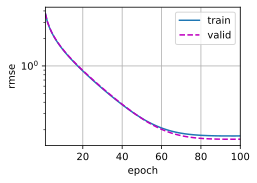

In [13]:
# 模型选择
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f'{k}-折验证：平均训练log rmse：{float(train_l):f},'f'平均验证log rmse：{float(valid_l):f}')
d2l.plt.show()#这一行是我自己加的 不然不出图
# 这里在进行k折交叉验证，训练的结果没有保留 因为单独调用了`get_net()`，后面训练预测的时候又调用了`get_net`，它们是不同的模型实例

上图训练误差和验证误差都在减小，以此看出没有过拟合？

train log rmse 0.162338


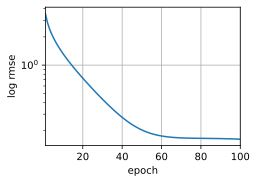

In [14]:
def train_and_pred(train_features, test_feature, train_labels, test_data, num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
            ylabel = 'log rmse', xlim=[1,num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1,-1)[0])
    submission = pd.concat([test_data['Id'],test_data['SalePrice']],axis=1)
    submission.to_csv('limu_submission.csv',index = False)
    
train_and_pred(train_features, test_features, train_labels, test_data,
              num_epochs, lr, weight_decay, batch_size)
d2l.plt.show()#这一行是我自己加的 不然不出图